In [812]:
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score

# Timeseries

from statsmodels.tsa.stattools import adfuller
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# Connect to SQL database
import sqlite3

In [210]:
# Import table
connex = sqlite3.connect('bixi_data.db')  
cur = connex.cursor()
df = pd.read_sql_query("SELECT * FROM df_clean", connex)
cur.close()

In [213]:
ts = df.copy(deep = False) # Different manipulation for TimeSeries
ts['date_hour'] = pd.to_datetime(ts['date_hour'])
ts = ts.set_index('date_hour')

### Random Forest for regressor selection in SARIMAX 

In [155]:
df.date_hour = pd.to_datetime(df.date_hour)
df['hour'] = df.date_hour.dt.hour
df['month'] = df.date_hour.dt.month

In [156]:
df.head(2)

,date_hour,bixi_rentals,day_ind,feels_like,heat_index,precip_hrly,precip_total,humidity,temp,uv_index,wind_speed,condition,is_weekend,is_holiday,hour,month
0,2018-04-11 00:00:00,50,0.0,27.0,32.0,0.0,0.0,83.0,32.0,0.0,6.0,Fair,0,0,0,4
1,2018-04-11 01:00:00,27,0.0,26.0,34.0,0.0,0.0,75.0,34.0,0.0,10.0,Fair,0,0,1,4


In [109]:
def create_dummies(col_names, df):
    """
    Returns Dataframe after creating dummy variables for all columns mentioned in col_names list
    for the dataframe df
    """
    for col in col_names:
        dummy = pd.get_dummies(df[col], prefix = f'{col}')
        df.drop([col], axis = 1 , inplace = True)
        df = pd.concat([df,dummy] , axis = 1)
    return df
    

In [161]:
# df = create_dummies(['condition','day_ind','is_weekend','is_holiday','month','hour'], df)


In [157]:
df = df.drop(['date_hour'],axis = 1)

In [163]:
X = df.drop(['bixi_rentals'], axis = 1)
y = df[['bixi_rentals']]

In [164]:
#split our data into a test and train set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20)

In [165]:
rf = RandomForestClassifier(criterion = 'gini', max_depth = 14, n_estimators = 150)
rf.fit(X_train, y_train)

/Users/pacman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [166]:
y_train_hat = rf.predict(X_train)
y_test_hat = rf.predict(X_test)

In [167]:
# Residuals
resid = pd.DataFrame(abs(y_train.values.flatten() - y_train_hat), columns=['residual'])

In [168]:
resid[resid['residual'] != 0].sort_values(by = 'residual', ascending = False).head(10)

,residual
2193,1048
1511,1017
792,916
1961,845
3653,836
1711,756
3719,742
198,673
2016,624
2490,608


In [169]:
r2_score(y_train.values.flatten(), y_train_hat)

0.997354195415717

In [170]:
r2_score(y_test.values.flatten(), y_test_hat)

0.6485180542966866

In [143]:
mean_squared_error(y_train.values.flatten(), y_train_hat)

585.3036311514572

In [144]:
mean_squared_error(y_test.values.flatten(), y_test_hat)

135436.37917860554

In [ ]:
# Grid Search
param_grid_rf = {'criterion' : ['gini','entropy'],
                 'max_depth': [5,10],
                 'n_estimators': [100, 115, 150]}
In [86]:
# Instantiating Random Forest classifier 
forest = RandomForestClassifier()
grid_rf = GridSearchCV(forest, param_grid = param_grid_rf) # default cv = 3
grid_rf.fit(X_train, y_train)

In [172]:
def plot_feature_importances(model):
    n_features = len(X.columns)
    plt.figure(figsize=(13,10))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), list(X.columns)) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

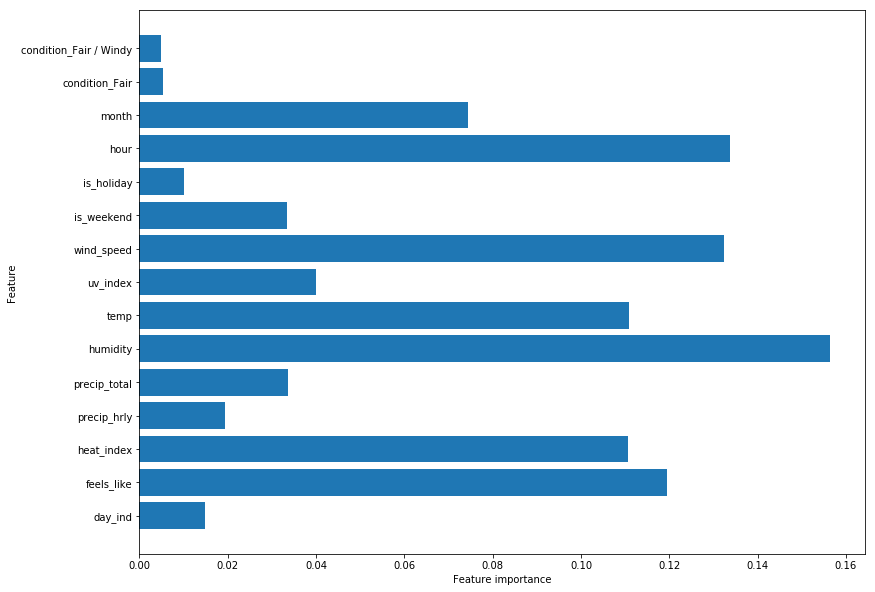

In [173]:
plot_feature_importances(rf)

### Time Series analysis

In [518]:
X = ts[['humidity','feels_like','precip_hrly']]
y = ts[['bixi_rentals']]

In [393]:
# Seasonality seems to be present as patterns seem to repeat every 7 days.
# It makes sense to compare the same day of the week at the same hour to remove seasonality.

def stationarity_check(df, window = 24):
    
    rcParams['figure.figsize'] = 18, 8
    rolmean = df.dropna().rolling(window = window).mean()
    rolstd = df.rolling(window = window, center = False).std()
    
    fig = plt.figure(figsize=(18,8))
    orig = plt.plot(df.dropna(), color='teal',label='Original', alpha = 0.25)
    mean = plt.plot(rolmean, color='yellow', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    decomp = seasonal_decompose(df.dropna(), model='additive', freq=24) # Repetition every week
    ax = decomp.plot()
    plt.show
    
    X = df.dropna().values.flatten()
    result = adfuller(X)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

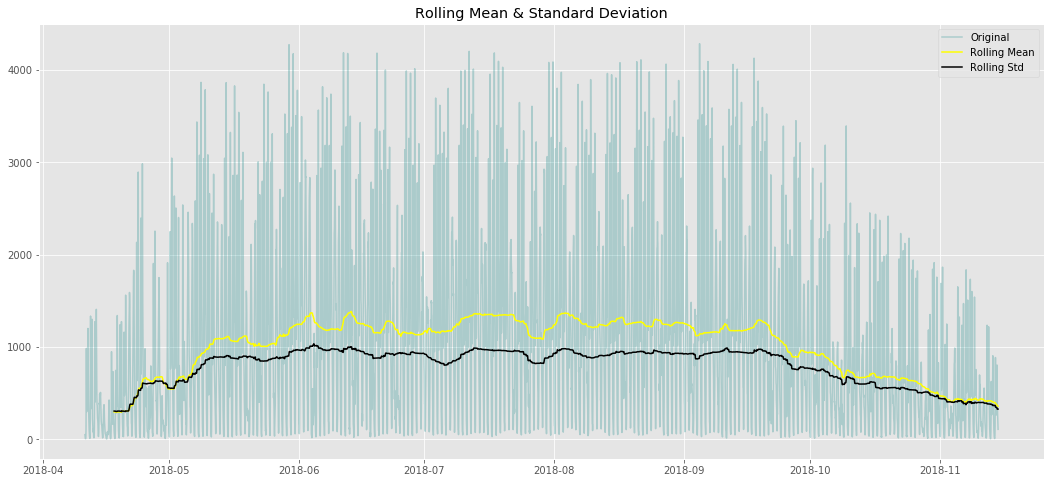

ADF Statistic: -5.604657
p-value: 0.000001
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


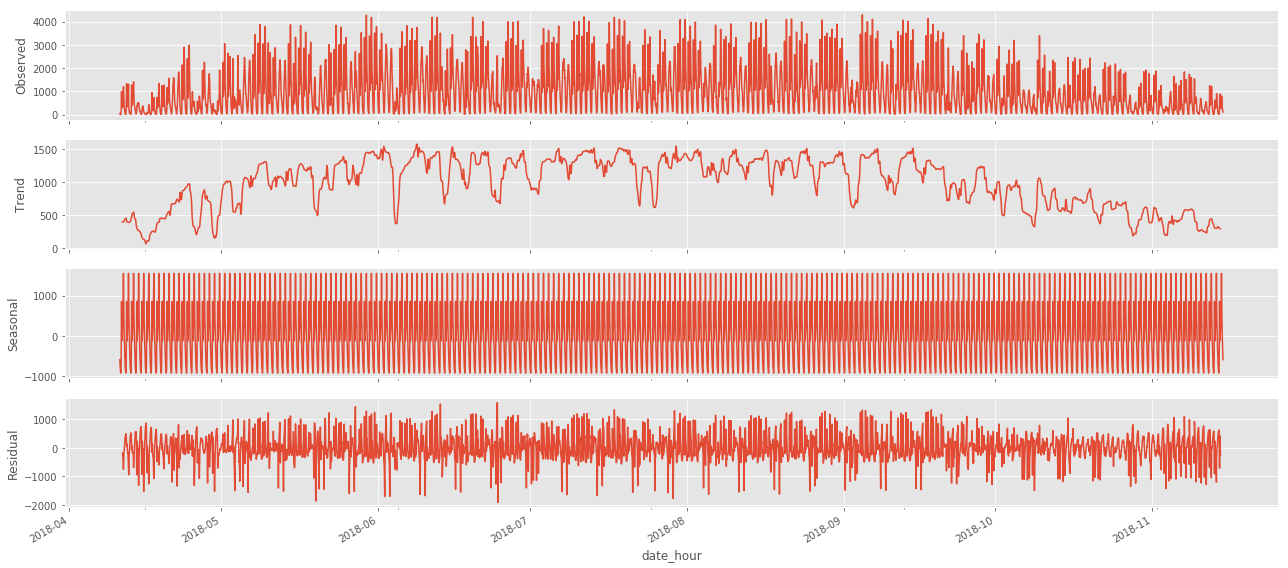

In [312]:
stationarity_check(y, 168)

### Decomposition + Base Model

In [519]:
y_shift = y - y.shift(168)
y_shift.dropna(inplace = True)

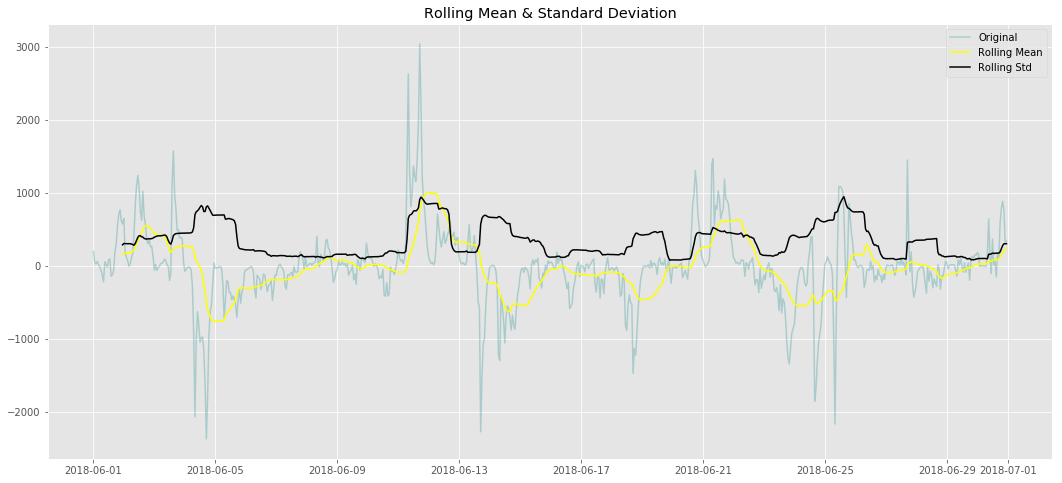

ADF Statistic: -4.064736
p-value: 0.001107
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


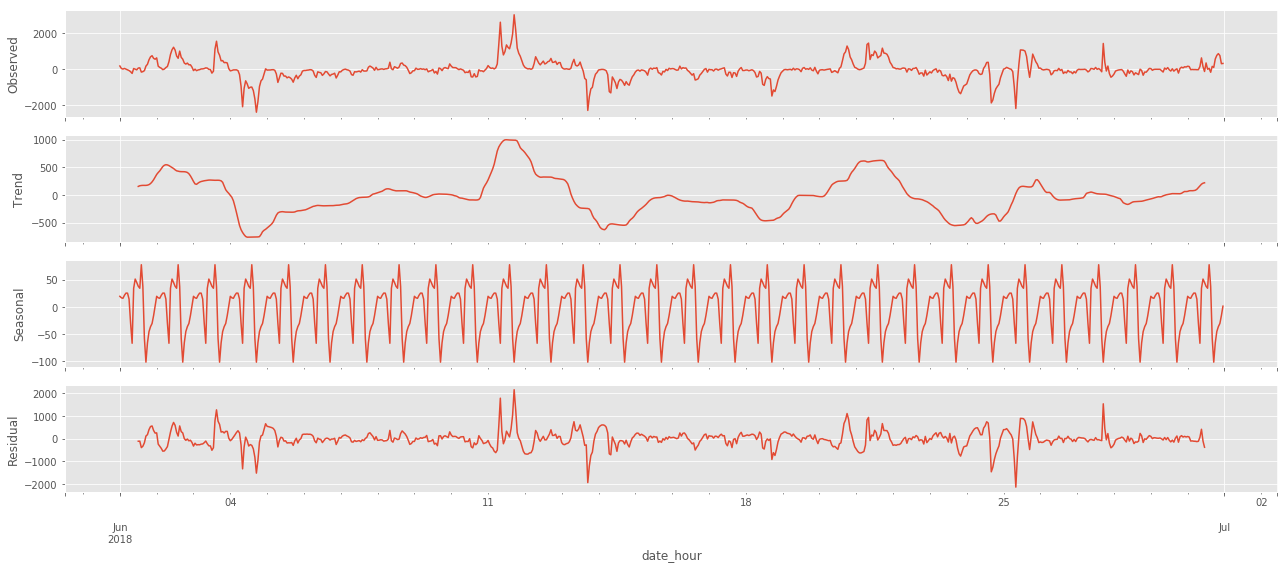

In [432]:
stationarity_check(y_shift['06-2018'])

<function matplotlib.pyplot.show(*args, **kw)>

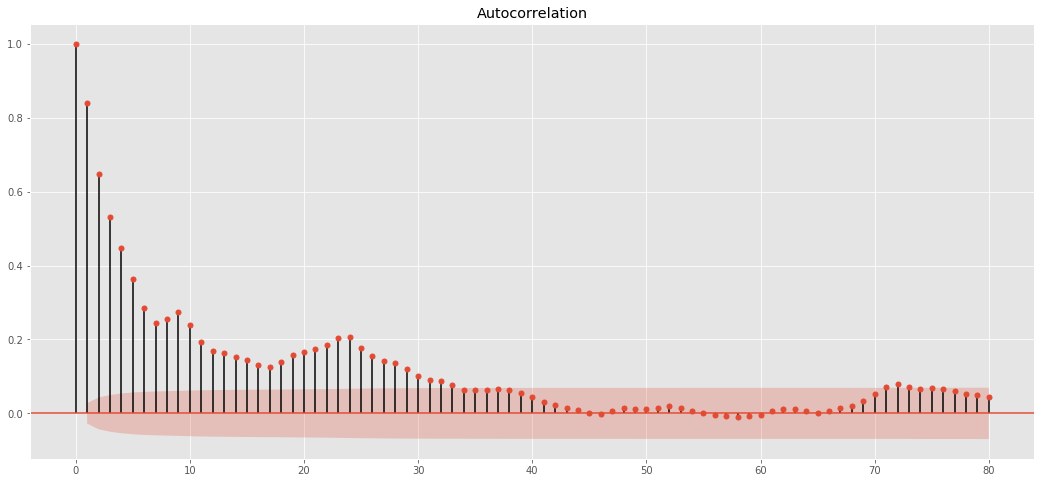

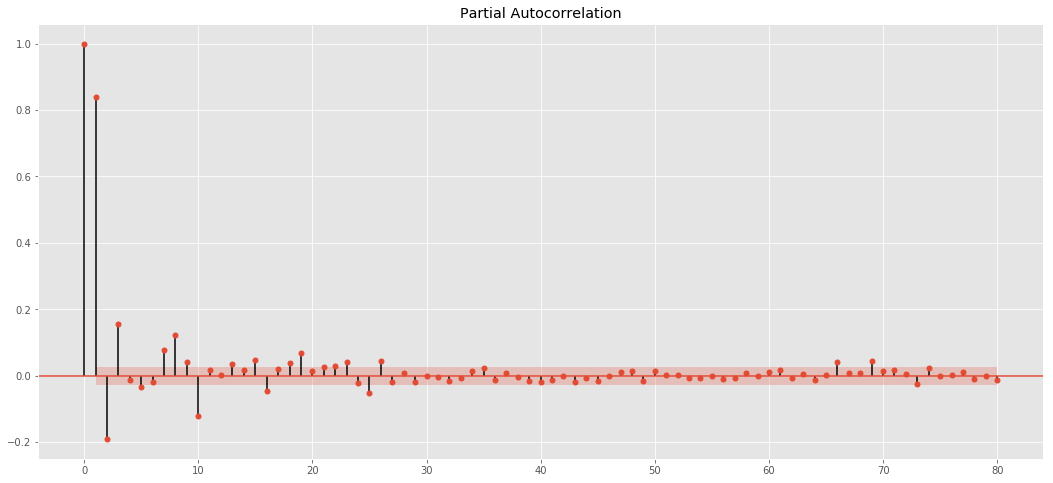

In [396]:
ax = plot_acf(y_shift, lags = 80)
ax = plot_pacf(y_shift, lags = 80, method='ywm')
plt.show

In [520]:
X_shift = X[168:] # No need to substract values from one week before for the weather

y_train, y_test = y_shift[:4052], y_shift[4052:] # Autoregression
X_train, X_test = X_shift[:4052], X_shift[4052:] # Exogenous variables

In [528]:
import statsmodels.api as sm

mod = sm.tsa.statespace.SARIMAX(
    endog = y_shift,
    exog = X_shift,
    order=(1,0,2),
    seasonal_order=(1,0,2,24),
    enforce_stationarity=False,
    enforce_invertibility=False)


output = mod.fit()
output.summary()

/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


KeyboardInterrupt: 

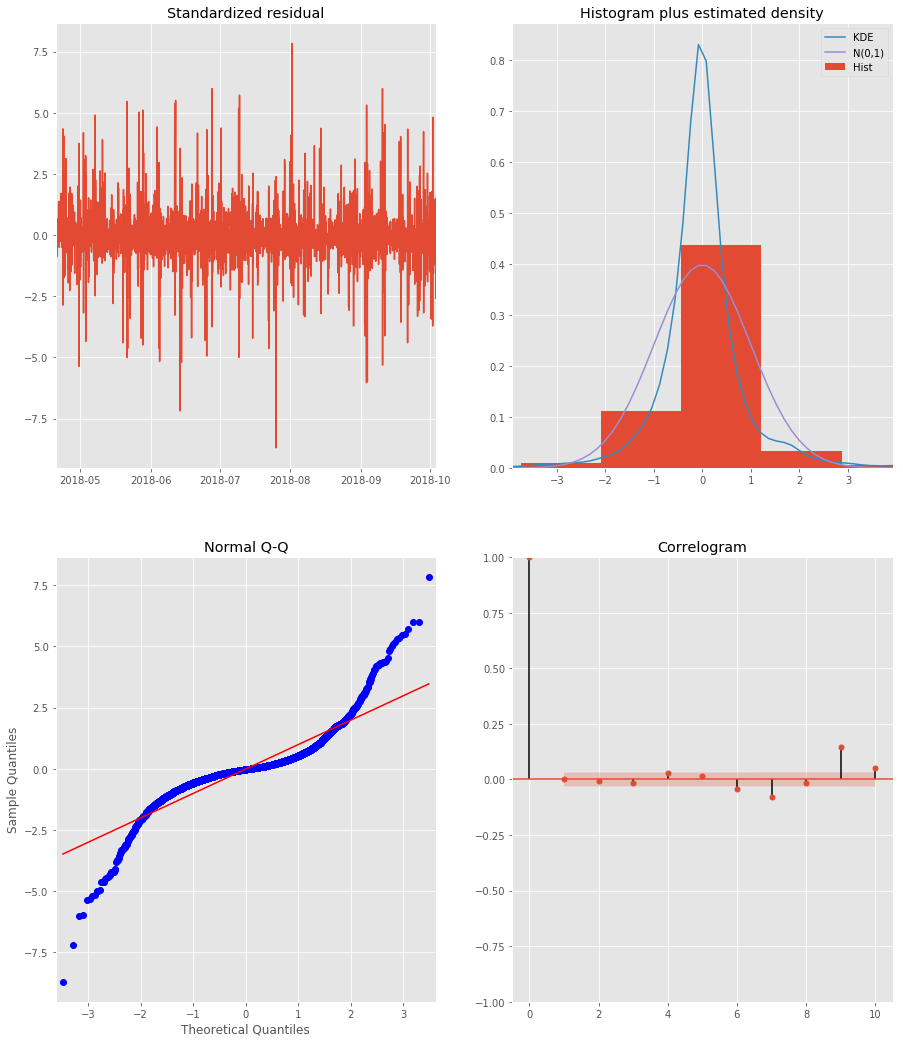

In [472]:
output.plot_diagnostics(figsize=(15, 18));

In [512]:
pred = output.get_prediction(start = 4052, dynamic=False, alpha =  0.05)
pred_conf = pred.conf_int()

ValueError: Out-of-sample forecasting in a model with a regression component requires additional exogenous values via the `exog` argument.

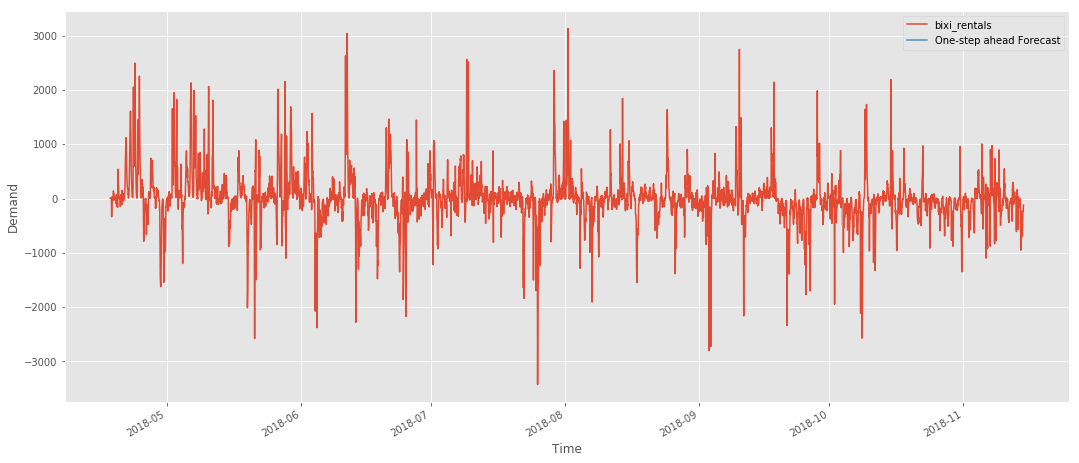

In [508]:
# rcParams['figure.figsize'] = 20,12

#Plot observed values
ax = y_shift.plot(label='observed')

#Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

#Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.5)

#Set axes labels
ax.set_xlabel('Time')
ax.set_ylabel('Demand')
plt.legend()

plt.show()

In [509]:
# Get the Real and predicted values
forecast = pred.predicted_mean.values
real = y_shift.values.flatten()

# RMSE
print('The Root Mean Squared Error of forecast is {}'.format(np.sqrt(mean_squared_error(forecast,real))))
print('R2 score is {}'.format(r2_score(forecast,real)))

ValueError: Found input variables with inconsistent numbers of samples: [1, 5065]

In [ ]:
# SARIMAX(1, 0, 1)x(0, 1, 1, 24) - AIC:72999.18045610248 - best so far with X
# SARIMAX(1, 0, 1)x(1, 1, 1, 24) - AIC 72454.686 - best so far 
# SARIMAX(1, 0, 1)x(2, 0, 1, 24) - AIC:69381.4435911726 - best so far (with X)
# SARIMAX(1, 0, 2)x(1, 0, 2, 24) - AIC:69362.10998913953 - best ..

In [420]:
import itertools

p = list(range(1,3))
d = [0]
q = list(range(1,3))
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]


In [422]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(endog= y_shift,
                                            exog= X[168:],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 24) - AIC:69666.55412383129


/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 0, 2, 24) - AIC:69530.18784715844


/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(2, 0, 1, 24) - AIC:69381.4435911726


/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(2, 0, 2, 24) - AIC:69581.75530568213


/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(1, 0, 1, 24) - AIC:69709.40193960424


/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(1, 0, 2, 24) - AIC:69362.10998913953


/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(2, 0, 1, 24) - AIC:69558.04079628995


/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(2, 0, 2, 24) - AIC:69534.31397560464


/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(1, 0, 1, 24) - AIC:69875.53191737222


/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(1, 0, 2, 24) - AIC:69545.69111982515


/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(2, 0, 1, 24) - AIC:69561.21977367112


/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(2, 0, 2, 24) - AIC:69562.8042732034


/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(1, 0, 1, 24) - AIC:69843.82289259224


/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(1, 0, 2, 24) - AIC:69529.9734403397


/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(2, 0, 1, 24) - AIC:69543.57562015642


/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(2, 0, 2, 24) - AIC:69532.5332278152


### FB Prophet

In [229]:
# !pip install pystan
# !conda install -y -c conda-forge fbprophet

In [531]:
from fbprophet import Prophet

In [1009]:
ts_fb = y.reset_index().rename(columns = {'date_hour': 'ds', "bixi_rentals": "y"})

In [1010]:
ts_fb['heat_index'] = df['heat_index']
ts_fb['precip_hrly'] = df['precip_hrly']
ts_fb['humidity'] = df['humidity']
ts_fb['wind_speed'] = df['wind_speed']
ts_fb['holiday'] = df['is_holiday']
ts_fb[:4000].tail()

,ds,y,heat_index,precip_hrly,humidity,wind_speed,holiday
3995,2018-09-24 11:00:00,919,49.0,0.0,48.0,13.0,0
3996,2018-09-24 12:00:00,1084,51.0,0.0,41.0,12.0,0
3997,2018-09-24 13:00:00,1199,54.0,0.0,36.0,6.0,0
3998,2018-09-24 14:00:00,1090,55.0,0.0,33.0,12.0,0
3999,2018-09-24 15:00:00,1407,57.0,0.0,32.0,8.0,0


In [1011]:
holidays = ts_fb[['ds','holiday']]
holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5233 entries, 0 to 5232
Data columns (total 2 columns):
ds         5233 non-null datetime64[ns]
holiday    5233 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 81.8 KB


In [1139]:

def fit_predict(ts_fb, train_obs, include_history = False):
    
    """
    Takes in dataframe with columns ds, y for target variable, eXogenous variables as first argument (ts_fb)
    and number of training observations as second argument (train_obs). Returns model (m) and forecast using 
    the rest of the observations to test.
    """
    
    if train_obs <= 1:
        return "train_obs parameter should be above 1, choose an appropriate number of observations for training"
    
    else:
        
        m = Prophet(yearly_seasonality=False,
#                     daily_seasonality=True,          
                    weekly_seasonality=True,
#                      holidays = holidays,
                    interval_width=0.95,
                    changepoint_prior_scale= 0.9)   # change_prior_scale decreased to make the trend less flexible
        
        m.add_seasonality('dai', period = 24, fourier_order= 10)
        m.add_regressor('heat_index')
        m.add_regressor('precip_hrly')
        m.add_regressor('humidity')
        m.add_regressor('wind_speed')
        m.add_country_holidays(country_name='Canada')

        #  Train model up to train_obs' index
        m.fit(ts_fb[:train_obs])  

        # Test model starting at last observation from train_obs
        future = m.make_future_dataframe(periods=(ts_fb.shape[0] - train_obs),
                                         freq = 'H',
                                         include_history = include_history)
        
        # Adding Exogenous variables to future dataframe needed to predict y
        future['heat_index'] = ts_fb.heat_index[train_obs:].reset_index().drop(['index'],axis = 1)
        future['precip_hrly'] = ts_fb.precip_hrly[train_obs:].reset_index().drop(['index'],axis = 1)
        future['humidity'] = ts_fb.humidity[train_obs:].reset_index().drop(['index'],axis = 1)
        future['wind_speed'] = ts_fb.wind_speed[train_obs:].reset_index().drop(['index'],axis = 1)

        forecast = m.predict(future)
        
        return m, forecast

In [1140]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [1141]:
m, forecast = fit_predict(ts_fb.drop(['holiday'],axis =1), train_obs=4000)

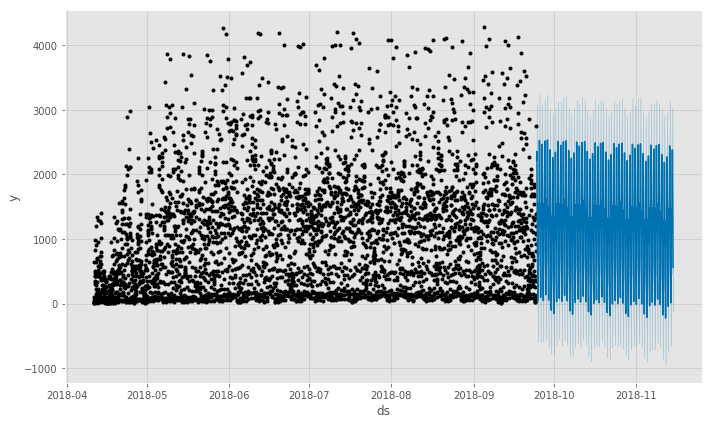

In [1142]:
from fbprophet.plot import add_changepoints_to_plot

fig1 = m.plot(pres1)

In [1143]:
# rmse_noX = rmse(forecast,y)
# rmse_noX

In [1144]:
rmse(forecast,y)


RMSE: 497.50076273277307 and MAE: 387.9419062573341


(                            yhat  bixi_rentals
 date_hour                                     
 2018-09-24 16:00:00  2382.253231          2403
 2018-09-24 17:00:00  2498.381436          3393
 2018-09-24 18:00:00  2333.517016          2178
 2018-09-24 19:00:00  1930.550106          1434
 2018-09-24 20:00:00  1457.239495           948
 2018-09-24 21:00:00  1095.379363           815
 2018-09-24 22:00:00   757.458453           528
 2018-09-24 23:00:00   635.378361           294
 2018-09-25 00:00:00   573.245341           187
 2018-09-25 01:00:00   438.493914            79
 2018-09-25 02:00:00   210.225266            53
 2018-09-25 03:00:00    -4.768041            45
 2018-09-25 04:00:00    41.639291            26
 2018-09-25 05:00:00   311.904874            96
 2018-09-25 06:00:00   784.841394           374
 2018-09-25 07:00:00  1278.496511          1369
 2018-09-25 08:00:00  1513.935949          2645
 2018-09-25 09:00:00  1447.781060           800
 2018-09-25 10:00:00   971.318600       

In [1145]:
from fbprophet.diagnostics import cross_validation, performance_metrics

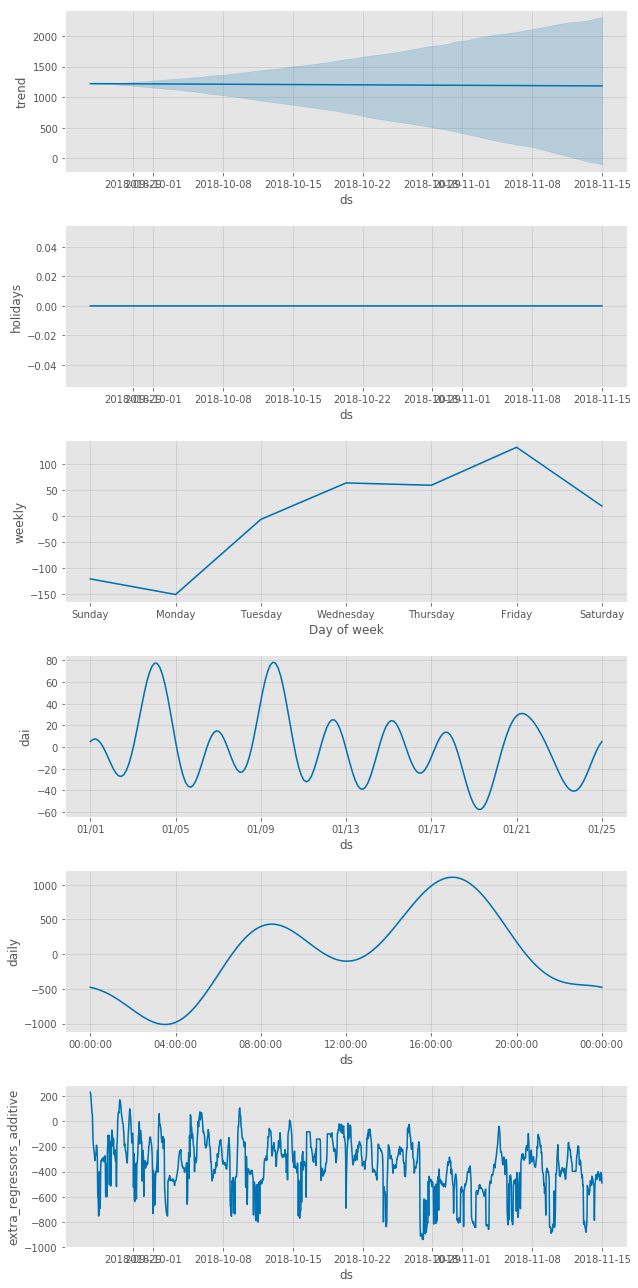

In [1146]:
fig2 = m.plot_components(forecast)

In [1147]:
from sklearn.metrics import mean_absolute_error

def rmse(forecast, ts):
    """
    Function takes in 2 dataframes: forecast from FB Prophet and Timeseries (ts) containing actual values and
    returns Root mean square error (RMSE).
    """

    df = forecast[['ds','yhat']].rename(columns = {'ds': 'date_hour'})
    df['date_hour'] = pd.to_datetime(df['date_hour'])
    df = df.set_index('date_hour')
    
    # Merge on index, by default merge takes inner join
    df = pd.merge(df, ts, left_index=True, right_index=True)[['yhat', 'bixi_rentals']]
    
    # Calculate RMSE
    RMSE = np.sqrt(mean_squared_error(df['yhat'],df['bixi_rentals']))
    
    MAE = mean_absolute_error(df['yhat'], df['bixi_rentals'])
    to_print = print(f'RMSE: {RMSE} and MAE: {MAE}')
    return df, to_print

In [1148]:
df, to_print = rmse(forecast,y)

RMSE: 497.50076273277307 and MAE: 387.9419062573341


In [1149]:
df['error'] = (df['yhat'] - df['bixi_rentals'])

In [1154]:
df.head(25)

,yhat,bixi_rentals,error
date_hour,,,
2018-09-24 16:00:00,2382.253231,2403,-20.746769
2018-09-24 17:00:00,2498.381436,3393,-894.618564
2018-09-24 18:00:00,2333.517016,2178,155.517016
2018-09-24 19:00:00,1930.550106,1434,496.550106
2018-09-24 20:00:00,1457.239495,948,509.239495
2018-09-24 21:00:00,1095.379363,815,280.379363
2018-09-24 22:00:00,757.458453,528,229.458453
2018-09-24 23:00:00,635.378361,294,341.378361
2018-09-25 00:00:00,573.245341,187,386.245341


In [1151]:
dodo = df.reset_index()

(427175.65, 427271.35)

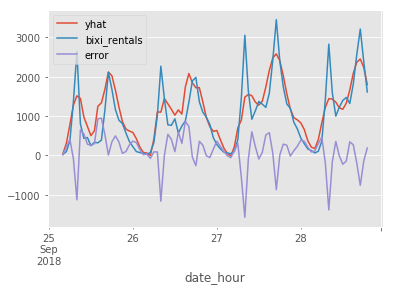

In [1152]:
ax = dodo[12:100].plot(x = 'date_hour')
ax.set_xlim()



## Algo options

#### Deep Learning - because of weather or event in the city that will hike up the demand